In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
import tensorflow as tf

from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model, load_model
from keras.datasets import mnist 
from keras import backend as K 

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255
X_test = X_test / 255

img_width = X_train.shape[1]
img_height = X_train.shape[2]
num_channels = 1

X_train = X_train.reshape(X_train.shape[0], img_height, img_width, num_channels)
X_test = X_test.reshape(X_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

In [3]:
latent_dim = 2 

input_img = Input(shape=input_shape)
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim)(x)
z_sigma = Dense(latent_dim)(x)

def sample_z(args):
    z_mu, z_sigma = args
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    return z_mu + K.exp(z_sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ))([z_mu, z_sigma])

encoder = Model(input_img, [z_mu, z_sigma, z])
print(encoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                              

In [4]:
decoder_input = Input(shape=(latent_dim, ))

x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       18464     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable

In [5]:
z_decoded = decoder(z)

In [6]:
class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomLayer()([input_img, z_decoded])
vae = Model(input_img, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

In [7]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('vae_mnist_model.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    # tf.keras.callbacks.TensorBoard(log_dir='logs')
]

vae.fit(X_train, None, epochs=10, batch_size=64, validation_split=0.1, callbacks=[checkpointer, callbacks])

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - ETA: 0s - loss: 0.2374

C:\Users\86183\anaconda23-3\lib\site-packages\keras\engine\training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.21323, saving model to vae_mnist_model.h5
54000/54000 [==============================] - 80s 1ms/sample - loss: 0.2374 - val_loss: 0.2132
Epoch 2/10
54000/54000 [==============================] - ETA: 0s - loss: 0.2069
Epoch 2: val_loss improved from 0.21323 to 0.19929, saving model to vae_mnist_model.h5
54000/54000 [==============================] - 80s 1ms/sample - loss: 0.2069 - val_loss: 0.1993
Epoch 3/10
54000/54000 [==============================] - ETA: 0s - loss: 0.1971
Epoch 3: val_loss improved from 0.19929 to 0.19371, saving model to vae_mnist_model.h5
54000/54000 [==============================] - 78s 1ms/sample - loss: 0.1971 - val_loss: 0.1937
Epoch 4/10
54000/54000 [==============================] - ETA: 0s - loss: 0.1930
Epoch 4: val_loss improved from 0.19371 to 0.19052, saving model to vae_mnist_model.h5
54000/54000 [==============================] - 84s 2ms/sample - loss: 0.1930 - val_loss: 0.1905
Epoch 5/10
54000/54000 [====

C:\Users\86183\anaconda23-3\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


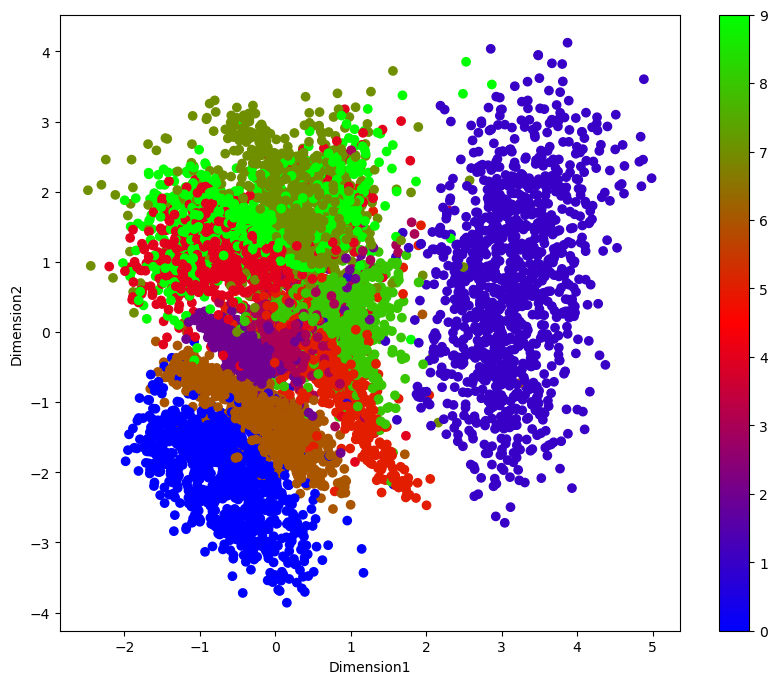

In [8]:
mu, _, _ = encoder.predict(X_test)
plt.figure(figsize=(10, 8))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('Dimension1')
plt.ylabel('Dimension2')
plt.colorbar()
plt.show()

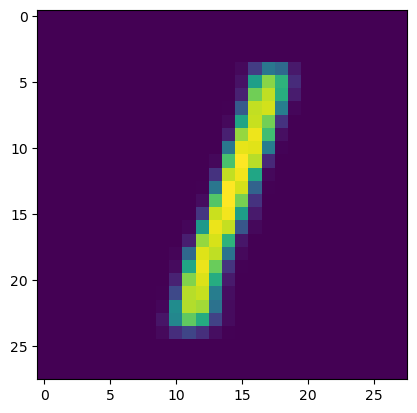

In [9]:
sample_vector = np.array([[3.5, 0]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)
plt.show()

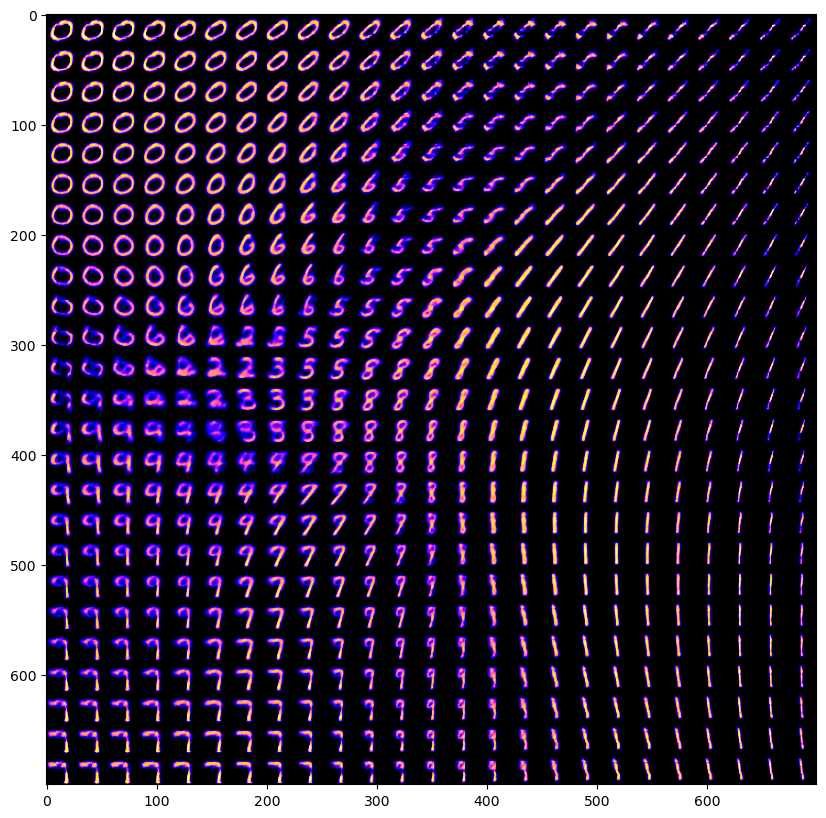

In [10]:
n = 25
figure = np.zeros((img_width * n, img_height * n, num_channels))

grid_x = np.linspace(-2, 5, n)
grid_y = np.linspace(-4, 4, n)

for i, y in enumerate(grid_y):
    for j, x in enumerate(grid_x):
        z_sample = np.array([[x, y]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width:(i + 1) * img_width, j * img_height:(j + 1) * img_height] = digit
        
plt.figure(figsize=(10, 10))
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()